# CSSE John Hopkins University 

Utilities to import Covid-19 data from CSSE JHU source.

The DB structure is created with SQLAlchemy. Currently I have only tested it with SQLite3 but it should work fine with any of the supported engines (MySQL, Postgres, Oracle, SQL Server).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import sys
from sqlalchemy import Column, ForeignKey, Integer, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship
from sqlalchemy import create_engine

## Some minimal variables

In [3]:
data_dir='/Users/max4946/DEVEL/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports'
base_dir=os.getcwd()
db_name="covid"

## DB Structure

In [4]:
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Date
from sqlalchemy import ForeignKey
from sqlalchemy.orm import relationship
from sqlalchemy.schema import UniqueConstraint
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

engine = create_engine('sqlite:///{}/{}.sqlite3'.format(base_dir,
            db_name), echo=False) # Move this to your liking for different engine
Session = sessionmaker(bind=engine)

# import logging

# logging.basicConfig()
# logging.getLogger('sqlalchemy.engine').setLevel(logging.FATAL)

Base = declarative_base()

class City(Base):
    __tablename__ = 'city_table'

    id = Column(Integer, primary_key=True)
    state_id = Column(Integer, ForeignKey('state_table.id'),
        nullable=False)
    
    name = Column(String)
    short_name = Column(String)
  
    state = relationship("State")

    def __repr__(self):
        return "<City(name='%s', short_name='%s')>" % (
                            self.name, self.short_name)


class State(Base):
    __tablename__ = 'state_table'

    id = Column(Integer, primary_key=True, nullable=False)
    country_id = Column(Integer, ForeignKey('country_table.id'),
        nullable=False)

    name = Column(String)
    short_name = Column(String)

    country = relationship("Country")
    
    def __repr__(self):
        return "<State(name='%s', short_name='%s')>" % (
                            self.name, self.short_name)

    
class Country(Base):
    __tablename__ = 'country_table'

    id = Column(Integer, primary_key=True)
    name = Column(String, nullable=False, unique=True)
    short_name = Column(String)
    nickname = Column(String)
 
    
    def __repr__(self):
        return "<Country(name='%s', short_name='%s', nickname='%s')>" % (
                            self.name, self.short_name, self.nickname)

    
class DailyData(Base):
    __tablename__ = 'daily_data'
    __table_args__ = (
        UniqueConstraint("country_id", 
                      "state_id", "city_id", 
                      "date", name = "location_date_c" ),
    )
  
    id = Column(Integer, primary_key=True)
    
    country_id = Column(Integer, ForeignKey('country_table.id'),
        nullable=False)
    country = relationship("Country")
    state_id = Column(Integer, ForeignKey('state_table.id'),
        nullable=True)
    state = relationship("State")
    city_id = Column(Integer, ForeignKey('city_table.id'),
        nullable=True)
    city = relationship("City")
    
    date = Column(Date)
    confirmed = Column(Integer)
    recovered = Column(Integer)
    deaths = Column(Integer)

In [5]:
#engine

In [6]:
#Country.__table__, DailyData.__table__

## Create tables on the engine

In [7]:
Base.metadata.create_all(engine)

## A *range()* function for dates

In [8]:
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)+1):
        yield start_date + timedelta(n)

## Data importer *class*

In [9]:
import os.path
import csv

class csse_covid():
    """Read files from CSSE covid-19 daily report and put it 
    on a SQL database"""
    def __init__(self, data_dir):
        self.start_date = date(2020,4,14)
        self.end_date = date.today()
        self.data_dir = data_dir

    def run(self):
        self.read_files(self.start_date, self.end_date)
        
    def read_files(self, start_date, end_date):
        print(start_date, end_date)
        for d in daterange(start_date, end_date):
            print("Date: ", d)
            file = "{}/{}.csv".format(self.data_dir, 
                d.strftime("%m-%d-%Y"))
            if os.path.exists(file):
                data = pd.read_csv(file)
                data.fillna(0, inplace=True)
                self.to_sql(data, d)
            #break
    def to_sql(self, data, date):
        session = Session()
        data.columns = data.columns.str.replace('/',"_")
        data.columns = data.columns.str.replace(' ',"_")
        n_cols = len(data.columns)
        
        for r in data.itertuples():
            city = ""
            state = r.Province_State
            
            country = r.Country_Region
            confirmed = r.Confirmed
            recovered = r.Recovered
            deaths = r.Deaths

            if n_cols == 12:
                city = r.Admin2

            if state == "": # or np.isnan(state):
                state = country
                city = country
            # check/add Country
            country_q = session.query(Country).\
                filter(Country.name==country)
            if country_q.count() == 0:
                new_country = Country(name=country)
                session.add(new_country)
                session.commit()
                session.refresh(new_country)  
            elif country_q.count() == 1:
                new_country = country_q.first()
            # check/add State
            state_q = session.query(State).\
                filter(State.name==state).\
                filter(State.country_id==new_country.id)
            if state_q.count() == 0:
                new_state = State(name=state, country_id=new_country.id)
                session.add(new_state)
                session.commit()
                session.refresh(new_state)
            elif state_q.count() == 1:
                new_state = state_q.first()
            # check/add City
            city_q = session.query(City).\
                filter(City.name==city).\
                filter(City.state_id==new_state.id)
            if city_q.count() == 0:
                new_city = City(name=city, state_id=new_state.id)
                session.add(new_city)
                session.commit()
                session.refresh(new_city)
            elif city_q.count() == 1:
                new_city = city_q.first()
            
            daily_data = DailyData(date=date, country_id=new_country.id,
                    state_id=new_state.id, city_id=new_city.id, confirmed=confirmed,
                    recovered=recovered, deaths=deaths)
            try:
                session.add(daily_data)
                session.commit()
                session.refresh(daily_data)
                #print(daily_data)
            except:
                pass
                #print("Error, likely a duplicated row: {}".format(daily_data))
                session.rollback()




## Running the importer

In [10]:
Base.metadata.create_all(engine)
reader = csse_covid(data_dir)
reader.run()

2020-04-14 2020-04-26
Date:  2020-04-14
Date:  2020-04-15
Date:  2020-04-16
Date:  2020-04-17
Date:  2020-04-18
Date:  2020-04-19
Date:  2020-04-20
Date:  2020-04-21
Date:  2020-04-22
Date:  2020-04-23
Date:  2020-04-24
Date:  2020-04-25
Date:  2020-04-26


## Very basic testing for the imported data

In [11]:
session = Session()
q = session.query(DailyData).join(Country).filter(Country.name== "Mexico")
mx = pd.read_sql(q.statement, q.session.bind, index_col='date', parse_dates="date")
mx = mx[["confirmed","recovered","deaths"]].sort_index()
mx.sort_index()

,confirmed,recovered,deaths
date,,,
2020-01-23,0,0,0
2020-02-28,1,0,0
2020-02-29,4,0,0
2020-03-01,5,0,0
2020-03-02,5,0,0
2020-03-03,5,1,0
2020-03-04,5,1,0
2020-03-05,5,1,0
2020-03-06,6,1,0


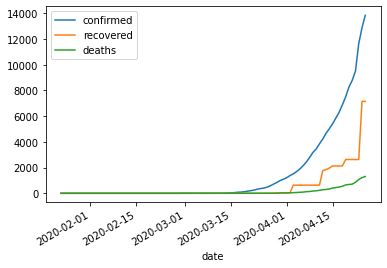

In [12]:
mx.plot()

In [13]:
6800/49000*100

13.877551020408163

# Playground (as usual)

In [14]:
#session = Session()

In [15]:
# test = Country(name='test', short_name='t', nickname='tt')
# session.add(test)
# session.commit()

In [ ]:
session = Session()
t = session.query(Country).filter(Country.name.like("t%"))
t.all()
#session.commit()

In [ ]:
print(t.statement, list(t.values()))

In [ ]:
# t.all()

In [ ]:
data = pd.read_csv("{}/01-23-2020.csv".format(data_dir))
data[data['Country/Region'] == 'Mexico']

In [ ]:
from sqlalchemy import func
session = Session()

state = "San Antonio, TX"
q = session.query(DailyData.date,
    func.sum(DailyData.confirmed).label('confirmed'),
    func.sum(DailyData.recovered).label('recovered'),
    func.sum(DailyData.deaths).label('deaths')
                 ).join(State).filter(State.name== state).group_by(DailyData.date)
data = pd.read_sql(q.statement, q.session.bind, index_col='date', parse_dates="date")
data = mx.sort_index()
data.tail()

In [ ]:
data["confirmed"].diff().plot(figsize=(10,5), title='{}: Confirmed'.format(state))

In [ ]:
data["deaths"].diff().plot(figsize=(10,5), title='{}: Deaths'.format(state))

In [ ]:
641/22795*100

In [ ]:
9385/189033*100

In [ ]:
data = None
data, city

In [ ]:
from sqlalchemy import func
session = Session()
data = None
city = "Bexar"
state = "Texas"
q = session.query(DailyData.date,
    func.sum(DailyData.confirmed).label('confirmed'),
    func.sum(DailyData.recovered).label('recovered'),
    func.sum(DailyData.deaths).label('deaths')).join(City).\
    filter(City.name==city).\
    group_by(DailyData.date)
data = pd.read_sql(q.statement, q.session.bind, index_col='date', parse_dates="date")
data = data.sort_index()
data.tail(20)

In [ ]:
data["confirmed"].plot(logy=False)

In [ ]:
data["confirmed"].diff().plot(logy=False)

In [ ]:
session = Session()
q = session.query(Country.name.label("Country"), Country.id,
                 func.count(State.id).label("states")
                 ).join(State).group_by(Country.id)
states = pd.read_sql(q.statement, q.session.bind)# , index_col='date', parse_dates="date")
#states = states[["confirmed","recovered","deaths"]].sort_index()
states.sort_values("states").tail(20)

In [ ]:
states.sort_values("states")

In [ ]:
session = Session()
q = session.query(Country.name, State.name, State.id).join(State).\
    filter(Country.name == "South Korea")

states = pd.read_sql(q.statement, q.session.bind)
pd.set_option('display.max_rows', None)
states